[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed.



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langchain_groq

In [ ]:
import os
import math
from datetime import datetime
from IPython.display import Image, display

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

# ------------------------------
# 🔐 Setup Groq API Key
# ------------------------------
os.environ["GROQ_API_KEY"] = ""  # replace with your real key

In [ ]:
llm = ChatGroq(model="openai/gpt-oss-120b")

# ------------------------------
# 🧰 Define Tools
# ------------------------------
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def get_area_of_circle(radius: float) -> float:
    """Calculate the area of a circle given its radius."""
    return round(math.pi * radius ** 2, 2)

def current_time() -> str:
    """Return the current date and time."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Bind tools to model
llm_with_tools = llm.bind_tools([multiply, get_area_of_circle, current_time])

# ------------------------------
# ⚙️ Define LLM Node
# ------------------------------
def tool_calling_llm(state: MessagesState):
    """LLM decides whether to call a tool or respond naturally."""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it.

 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

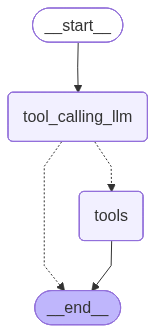

In [ ]:
# ------------------------------
# 🕸️ Build the Graph
# ------------------------------
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, get_area_of_circle, current_time]))

# Define edges
builder.add_edge(START, "tool_calling_llm")

# Conditional edge routes either to tools or directly to END
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)

builder.add_edge("tools", END)

# Compile the graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# ------------------------------
# 💬 Example 1 — Natural Response (No Tool)
# ------------------------------
print("\n=== Example 1: Normal Chat ===")
messages = [HumanMessage(content="Hello there! How are you?")]
result = graph.invoke({"messages": messages})
for msg in result["messages"]:
    msg.pretty_print()

# ------------------------------
# 🔢 Example 2 — Tool Invocation (Math)
# ------------------------------
print("\n=== Example 2: Math Tool Call ===")
messages = [HumanMessage(content="What is 2 multiplied by 3?")]
result = graph.invoke({"messages": messages})
for msg in result["messages"]:
    msg.pretty_print()

# ------------------------------
# ⚪ Example 3 — Area Tool
# ------------------------------
print("\n=== Example 3: Circle Area ===")
messages = [HumanMessage(content="What’s the area of a circle with radius 4?")]
result = graph.invoke({"messages": messages})
for msg in result["messages"]:
    msg.pretty_print()

# ------------------------------
# 🕓 Example 4 — Time Tool
# ------------------------------
print("\n=== Example 4: Current Time ===")
messages = [HumanMessage(content="Can you tell me the current time?")]
result = graph.invoke({"messages": messages})
for msg in result["messages"]:
    msg.pretty_print()

print("\n🎉 Success! You now have:")
print(" - A Groq LLM agent using LangGraph")
print(" - A router graph with conditional edges")
print(" - Multiple tools and message-based state flow")


=== Example 1: Normal Chat ===
================================ Human Message =================================

Hello there! How are you?
================================== Ai Message ==================================

Hello! I'm doing great, thank you for asking. How can I assist you today?

=== Example 2: Math Tool Call ===
================================ Human Message =================================

What is 2 multiplied by 3?
================================== Ai Message ==================================

2 multiplied by 3 equals **6**.

=== Example 3: Circle Area ===
================================ Human Message =================================

What’s the area of a circle with radius 4?
================================== Ai Message ==================================
Tool Calls:
  get_area_of_circle (fc_50023ad7-770d-49a2-afd7-bab90dfe2ee4)
 Call ID: fc_50023ad7-770d-49a2-afd7-bab90dfe2ee4
  Args:
    radius: 4
================================= Tool Message ==============

Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.
Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

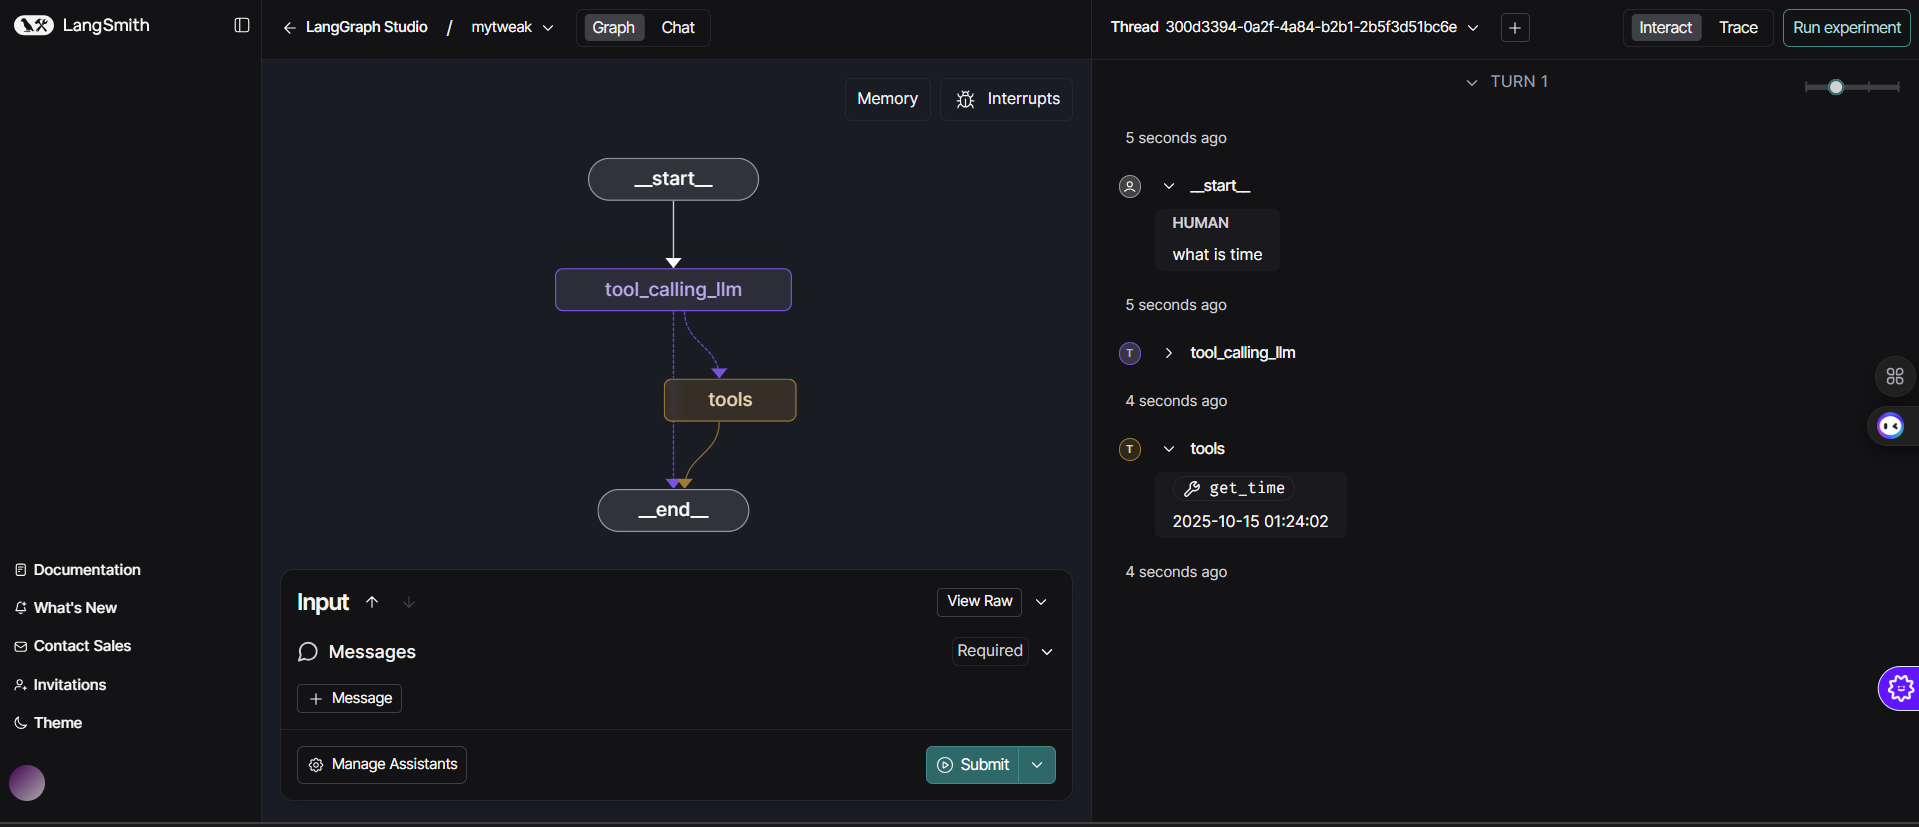

In [2]:
from IPython.display import Image
display(Image('/content/e.png'))